In [1]:
import pandas as pd
import numpy as np
import os
import warnings
from math import pi
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas.io.sql as pd_sql
from sqlalchemy import create_engine
import sqlite3 as sql
from datetime import datetime
sns.set(color_codes=True)
warnings.filterwarnings('ignore') # silence annoying warningsn

In [2]:
### Connextion python et cassandra
from cassandra.cluster import Cluster

cluster = Cluster(['172.17.0.2'], port=9042)
session = cluster.connect()

row = session.execute("SELECT * FROM products;").one()
if row:
    print(row[0])

/kaggle/working


Directory changed successfully 

/kaggle/input


aisles.csv
departments.csv
order_products__prior.csv
order_products__train.csv
orders.csv
products.csv
sample_submission.csv



In [5]:
"""The table name is self-explanatory"""
# Explore Aisles
aisles = pd.read_sql_query("SELECT * FROM aisles LIMIT 5 ;", conn)
print('Total aisles: {}'.format(aisles.shape[0]))
print("Aisles Table\n",aisles.head(),"\n\n")


# Explore Departments
departments = pd.read_sql_query("SELECT * FROM departments LIMIT 5 ;", conn)
print('Total departments: {}'.format(departments.shape[0]))
print('Departments Table\n',departments.head(),"\n\n")

# Explore Products csv
products = pd.read_sql_query("SELECT * FROM products LIMIT 5 ;", conn)
print('Total products: {}'.format(products.shape[0]))
print("Products Table\n",products.head(),"\n\n")

# Explore orders csv
orders = pd.read_sql_query("SELECT * FROM orders LIMIT 5 ;", conn)
print('Total orders: {}'.format(orders.shape[0]))
""" This table contains the order and user linkage. Also, this table contains the day of week, 
  hour_of_day kind of fields"""
print("Orders Table\n",orders.head(5),"\n\n")

# Explore orders_train csv
orders_products_train = pd.read_sql_query("SELECT * FROM order_products__train LIMIT 5 ;", conn)
print('Total orders for training: {}'.format(orders_products_train.shape[0]))
""" This table contains linkage between product table and the orders table. 
  Also, this table will be usefule for prediction for reorder""" 
print("Orders_products_train\n",orders_products_train.head(5),"\n\n")

# Explore order_product_prior.csv
orders_products_prior = pd.read_sql_query("SELECT * FROM order_products__prior LIMIT 5;", conn)
""" This table contains linkage between product table and the orders table. 
  Also, this table will be usefule for prediction for reorder""" 
print('Total prior orders: {}'.format(orders_products_prior.shape[0]))
print("orders_products_prior\n",orders_products_prior.head(5),"\n\n")

del aisles,departments,products,orders,orders_products_train,orders_products_prior

Total aisles: 5
Aisles Table
    index  aisle_id                       aisle
0      1         1       prepared soups salads
1      2         2           specialty cheeses
2      3         3         energy granola bars
3      4         4               instant foods
4      5         5  marinades meat preparation 


Total departments: 5
Departments Table
    index  department_id department
0      1              1     frozen
1      2              2      other
2      3              3     bakery
3      4              4    produce
4      5              5    alcohol 


Total products: 5
Products Table
    index  product_id                                       product_name  \
0      1           1                         Chocolate Sandwich Cookies   
1      2           2                                   All-Seasons Salt   
2      3           3               Robust Golden Unsweetened Oolong Tea   
3      4           4  Smart Ones Classic Favorites Mini Rigatoni Wit...   
4      5           5   

In [6]:
# Combine aisles, departments and products to create goods table
"""The purpose of creating goods table is to analyze combinations of aisle, department and products"""
start = datetime.now()
drop_goods_table=""" DROP TABLE IF EXISTS goods;"""
conn.execute(drop_goods_table)
join_prod_dep_sql = """\
    CREATE TABLE goods AS
    SELECT p.*, d.department, a.aisle
    FROM products p
    INNER JOIN departments d ON p.department_id = d.department_id
    INNER JOIN aisles a ON p.aisle_id = a.aisle_id;
    """
conn.execute(join_prod_dep_sql)
goods = pd.read_sql_query("SELECT * FROM goods Limit 5;", conn)
goods_step_time = datetime.now()
print('\nTotal Time taken to delete and create goods table {}\n'.format((goods_step_time-start).total_seconds()))
print("Goods Table \n", goods.head(),"\n\n")


#Combine orders and the orders_prior dataframe
#creating indexes earlier reduced time from 8 minutes to 3 minutes
drop_orders_combined_table=""" DROP TABLE IF EXISTS orders_combined;"""
conn.execute(drop_orders_combined_table)
join_ordProdPrior_sql = """\
    CREATE TABLE orders_combined AS
    SELECT o.*, op.product_id, op.add_to_cart_order,op.reordered
    FROM orders o
    INNER JOIN order_products__prior op ON o.order_id = op.order_id;
    """
conn.execute(join_ordProdPrior_sql)
orders_combined = pd.read_sql_query("SELECT * FROM orders_combined Limit 5;", conn)

index_columns = [col for col in orders_combined.columns if col.find("_id")>-1]
for col in index_columns:
    create_indexes="CREATE INDEX index_%s on orders_combined (%s);" %(col+"_orders_combined",col)
    conn.execute(create_indexes)        
        
orders_combined_time = datetime.now()
print('\nTotal Time taken to delete and create orders_combined table {}\n'.format((orders_combined_time-goods_step_time).total_seconds()))
print("Orders_Combined Table \n", orders_combined.head(),"\n\n")


#create datamart with combined tables
drop_prior_datamart_table=""" DROP TABLE IF EXISTS prior_datamart;"""
conn.execute(drop_prior_datamart_table)
join_prior_datamart_sql = """\
    CREATE TABLE prior_datamart AS
    SELECT o.*, gd.product_id, gd.product_name,gd.department,gd.aisle
    FROM orders_combined o
    INNER JOIN goods gd
    ON o.product_id = gd.product_id;
    """
conn.execute(join_prior_datamart_sql)
prior_datamart = pd.read_sql_query("SELECT * FROM prior_datamart Limit 5;", conn)

index_columns = [col for col in orders_combined.columns if col.find("_id")>-1]
for col in index_columns:
    create_indexes="CREATE INDEX index_%s on prior_datamart (%s);" %(col+"_prior_datamart",col)
    conn.execute(create_indexes)        
        
prior_datamart_time = datetime.now()
print('\nTotal Time taken to delete and create prior_datamart table {}\n'.format((prior_datamart_time-orders_combined_time).total_seconds()))
print("prior_datamart Table \n", prior_datamart.head(),"\n\n")

del goods, orders_combined,prior_datamart



Total Time taken to delete and create goods table 4.491098

Goods Table 
    index  product_id                                       product_name  \
0      1           1                         Chocolate Sandwich Cookies   
1      2           2                                   All-Seasons Salt   
2      3           3               Robust Golden Unsweetened Oolong Tea   
3      4           4  Smart Ones Classic Favorites Mini Rigatoni Wit...   
4      5           5                          Green Chile Anytime Sauce   

   aisle_id  department_id department                       aisle  
0        61             19     snacks               cookies cakes  
1       104             13     pantry           spices seasonings  
2        94              7  beverages                         tea  
3        38              1     frozen                frozen meals  
4         5             13     pantry  marinades meat preparation   



Total Time taken to delete and create orders_combined table 8.

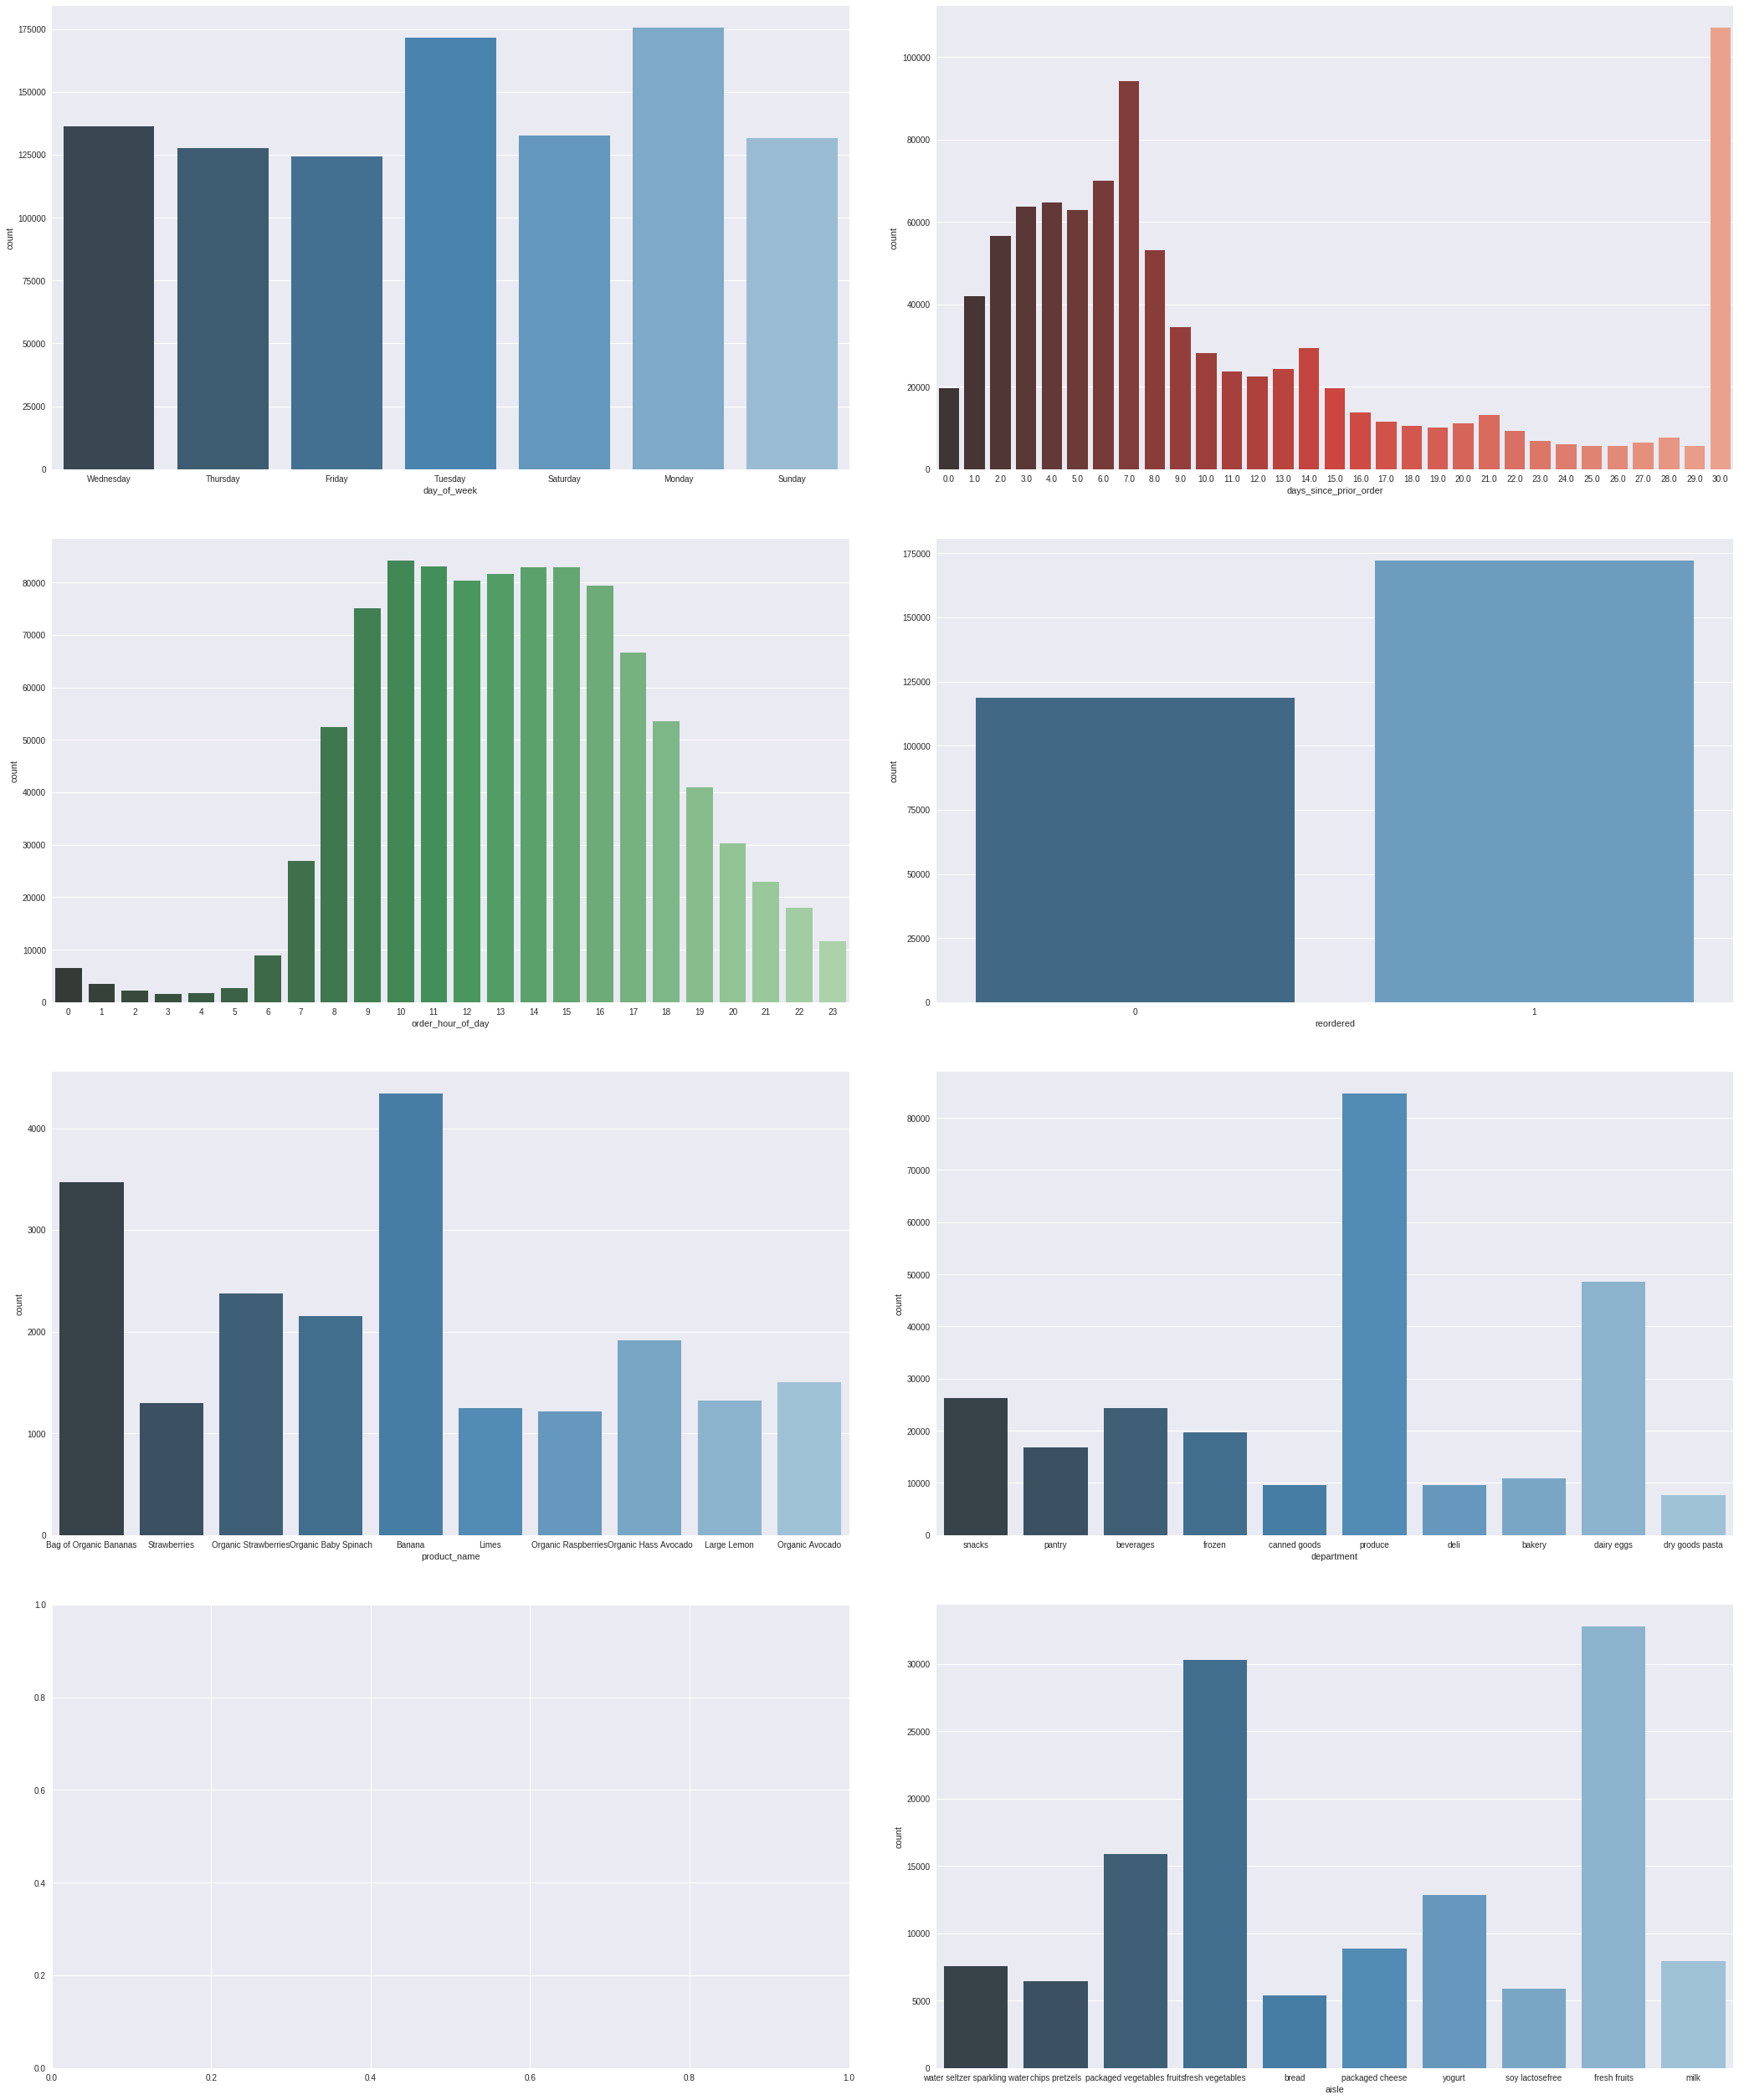

In [7]:
"""
Univariate Analysis
1. When do people order (Distribution of Time of Day) ?
2. Day of Week (Distribution of day_of_week)?
3. When do they order again (Distribution of Time Since Prior Order)?
4. How many prior orders are there (Distribution of Reorders)?
"""

#read the data from sqlite database to dataframe
orders = pd.read_sql_query("SELECT order_id, order_dow,days_since_prior_order,order_hour_of_day\
                            FROM orders;", conn)
goods = pd.read_sql_query("SELECT product_id,product_name,department,aisle FROM goods;", conn)
prior_datamart =  pd.read_sql_query("SELECT order_id, order_dow,days_since_prior_order,\
                                    order_hour_of_day,\
                                    product_id, product_name,department, aisle,reordered\
                                    FROM prior_datamart;", conn)
                                     

temp_df02 = pd.DataFrame(prior_datamart.groupby(['product_name']).agg({'order_id':pd.Series.nunique})
                         .rename(columns={'order_id':'cnt_ord_by_prod'})).reset_index()
temp_df03 = pd.DataFrame(prior_datamart.groupby(['department']).agg({'order_id':pd.Series.nunique})
                         .rename(columns={'order_id':'cnt_ord_by_dep'})).reset_index()
temp_df04 = pd.DataFrame(prior_datamart.groupby(['aisle']).agg({'order_id':pd.Series.nunique})
                         .rename(columns={'order_id':'cnt_ord_by_aisle'})).reset_index()

top_10_products = temp_df02.nlargest(10,'cnt_ord_by_prod')['product_name']
top_10_departments = temp_df03.nlargest(10,'cnt_ord_by_dep')['department']
top_10_aisle = temp_df04.nlargest(10,'cnt_ord_by_aisle')['aisle']

temp_df05= prior_datamart[prior_datamart['product_name'].isin(top_10_products)]
temp_df06= prior_datamart[prior_datamart['department'].isin(top_10_departments)]
temp_df07= prior_datamart[prior_datamart['aisle'].isin(top_10_aisle)]


days = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
orders['day_of_week']=pd.Series([days[dow] for dow in orders['order_dow']]) 
prior_datamart['day_of_week']=pd.Series([days[dow] for dow in prior_datamart['order_dow']]) 

plt.close('all')
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax7)) = plt.subplots(nrows=4,ncols=2)
fig.set_size_inches(30,36)
ax1=sns.countplot(x="day_of_week", ax=ax1,  data=orders,palette="Blues_d")        
ax2=sns.countplot(x="days_since_prior_order",ax=ax2,   data=orders,palette="Reds_d")
ax3=sns.countplot(x="order_hour_of_day",ax=ax3,   data=orders,palette="Greens_d")
ax4=sns.countplot(x="reordered",ax=ax4, data=prior_datamart,palette="Blues_d")
ax5=sns.countplot(x="product_name",ax=ax5, data=temp_df05,palette="Blues_d")
ax6=sns.countplot(x="department",ax=ax6, data=temp_df06,palette="Blues_d")
ax7=sns.countplot(x="aisle",ax=ax7, data=temp_df07,palette="Blues_d")
fig.tight_layout(h_pad=4,w_pad=4,pad=4)

del temp_df02,temp_df03,temp_df04,temp_df05,temp_df06,temp_df07


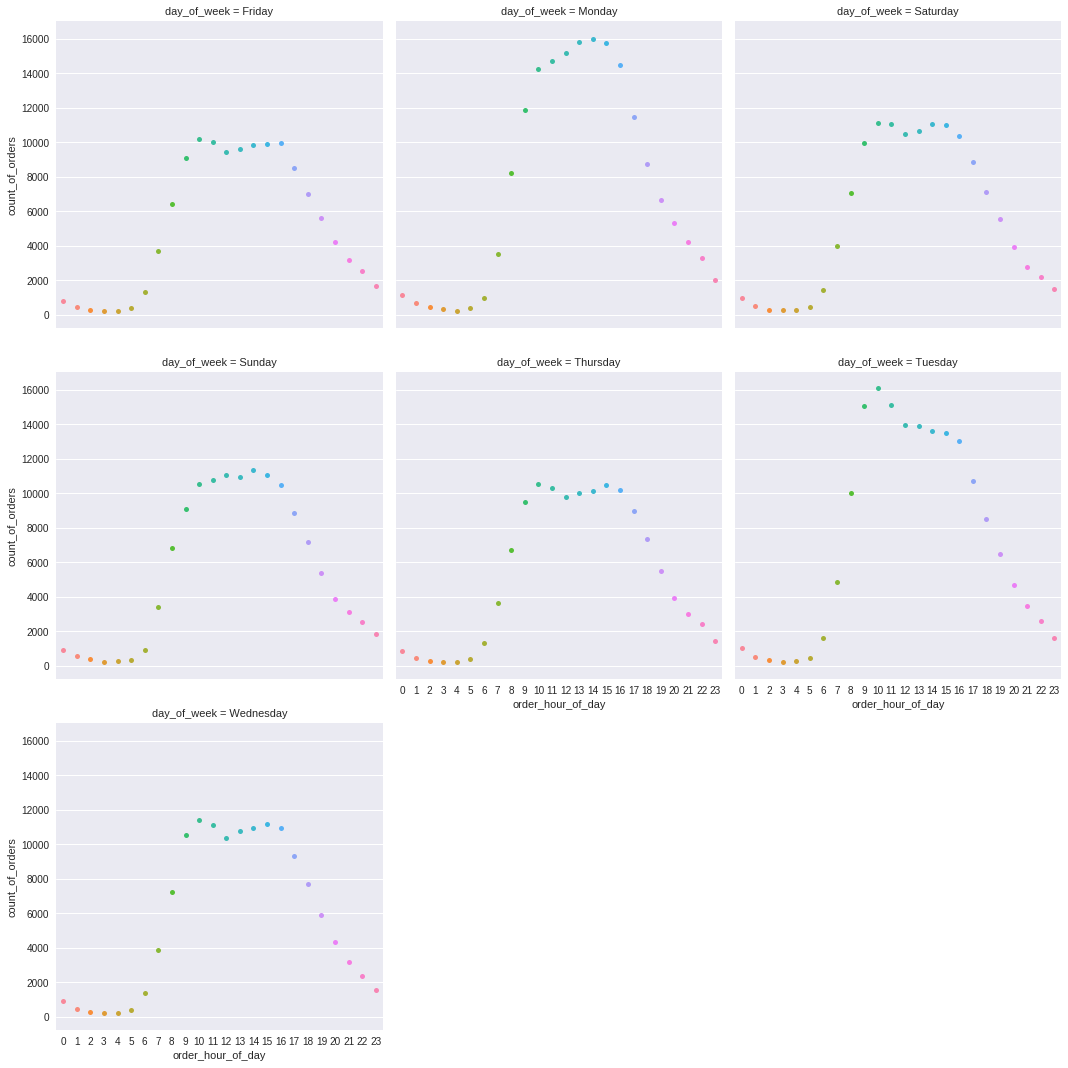

In [8]:
"""
Bivariate Analysis
1. When do people order (Distribution of Time of Day by orders) ?
2. Day of Week (Distribution of day_of_week by orders)?
"""
temp_df_01 = pd.DataFrame(orders.groupby(['day_of_week','order_hour_of_day'])
                          .agg({'order_id':pd.Series.nunique})
                          .rename(columns={'order_id':'count_of_orders'})).reset_index()
plt.close('all')
sns.factorplot(x="order_hour_of_day", y="count_of_orders",
               col="day_of_week", data=temp_df_01, kind="swarm",col_wrap=3,size=5);

del temp_df_01


 Top 10 products for Day and Time Combination
   day_of_week  order_hour_of_day            product_name  reordered  \
0      Friday                 14                  Banana          1   
1      Friday                 15                  Banana          1   
2      Friday                 12                  Banana          1   
3      Friday                  9                  Banana          1   
4      Friday                 16  Bag of Organic Bananas          1   

   count_of_reorders  
0                 43  
1                 42  
2                 39  
3                 37  
4                 35  


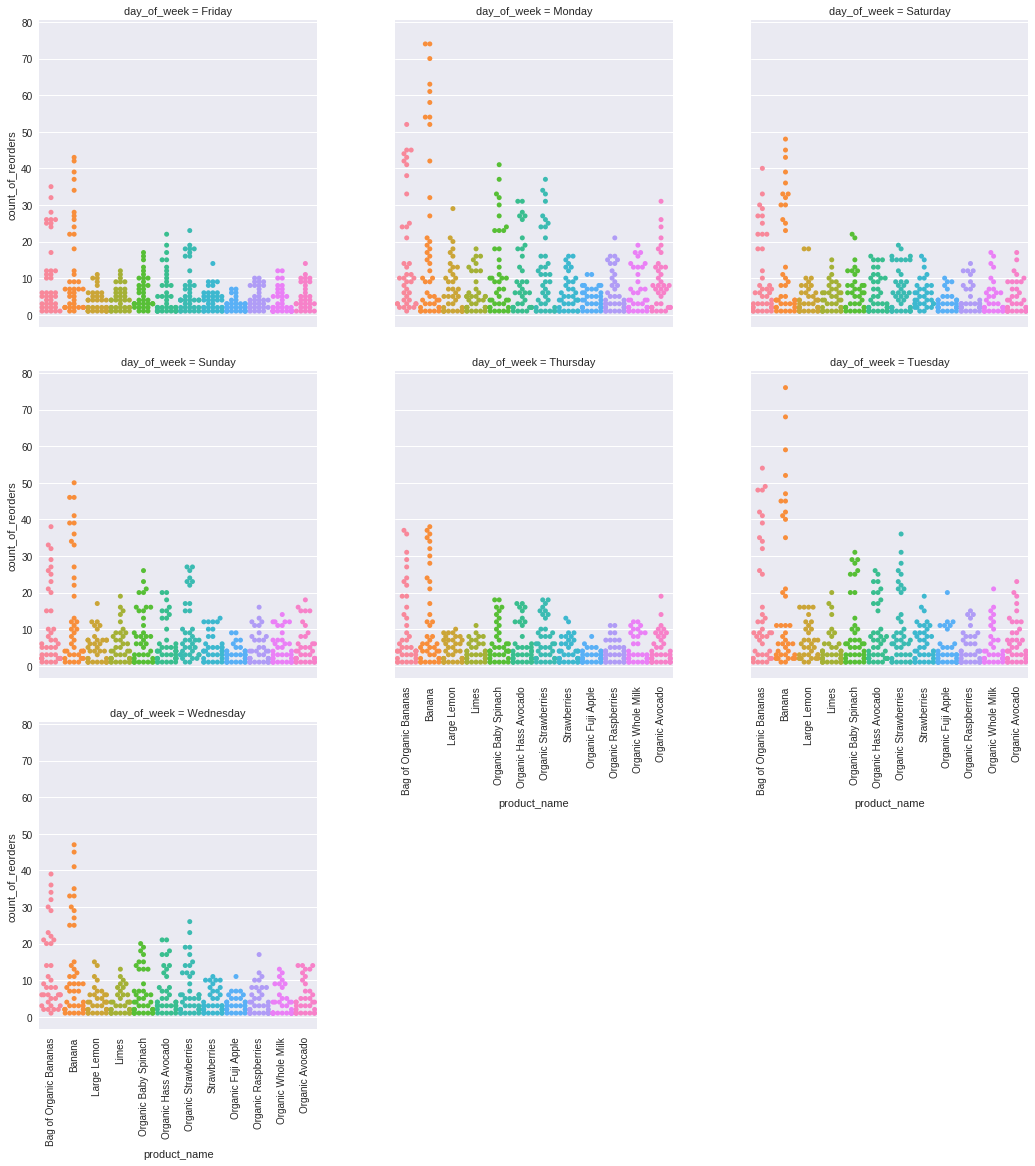

In [9]:
"""
Bivariate Analysis
Mondays and Tuesdays are busy days. It will be interesting to look for type of products ordered on Monday and Tuesdays
during the peak time
"""
temp_groupby_01= prior_datamart.groupby(['day_of_week','order_hour_of_day','product_name',
                                         'reordered']).agg({'order_id':
                                                            pd.Series.nunique}).rename(columns={'order_id':
                                                                                                'count_of_reorders'})
temp_groupby_02 = temp_groupby_01['count_of_reorders'].groupby(level=0, group_keys=False)

temp_df_01 = pd.DataFrame(temp_groupby_01).reset_index()
temp_df_02 = pd.DataFrame(temp_groupby_02.nlargest(50)).reset_index()

top_10_products_by_DayAndTime = temp_df_02[temp_df_02['reordered']==1]
print("\n Top 10 products for Day and Time Combination\n",top_10_products_by_DayAndTime.head(5))

#Limit data to only those products which are in top 10 category by any time and day combination
temp_df_01 = temp_df_01[temp_df_01['product_name'].isin(top_10_products_by_DayAndTime['product_name'])]

#Monday and Tuesday are of interest
#temp_df_01 = temp_df_01[temp_df_01['day_of_week'].isin(['Monday','Tuesday'])] 

#Most orders are between 6 and 20
#temp_df_01 = temp_df_01[(temp_df_01['order_hour_of_day'] >= 6) & (temp_df_01['order_hour_of_day'] <= 20) ]

plt.close('all')
g = sns.factorplot(x='product_name', y='count_of_reorders',
                   #col="day_of_week", data=temp_df_01[temp_df_01['reordered']==1], kind="swarm",col_wrap=3,size=5);
                   col="day_of_week", data=temp_df_01, kind="swarm",col_wrap=3,size=5);
g.set_xticklabels(rotation=90)

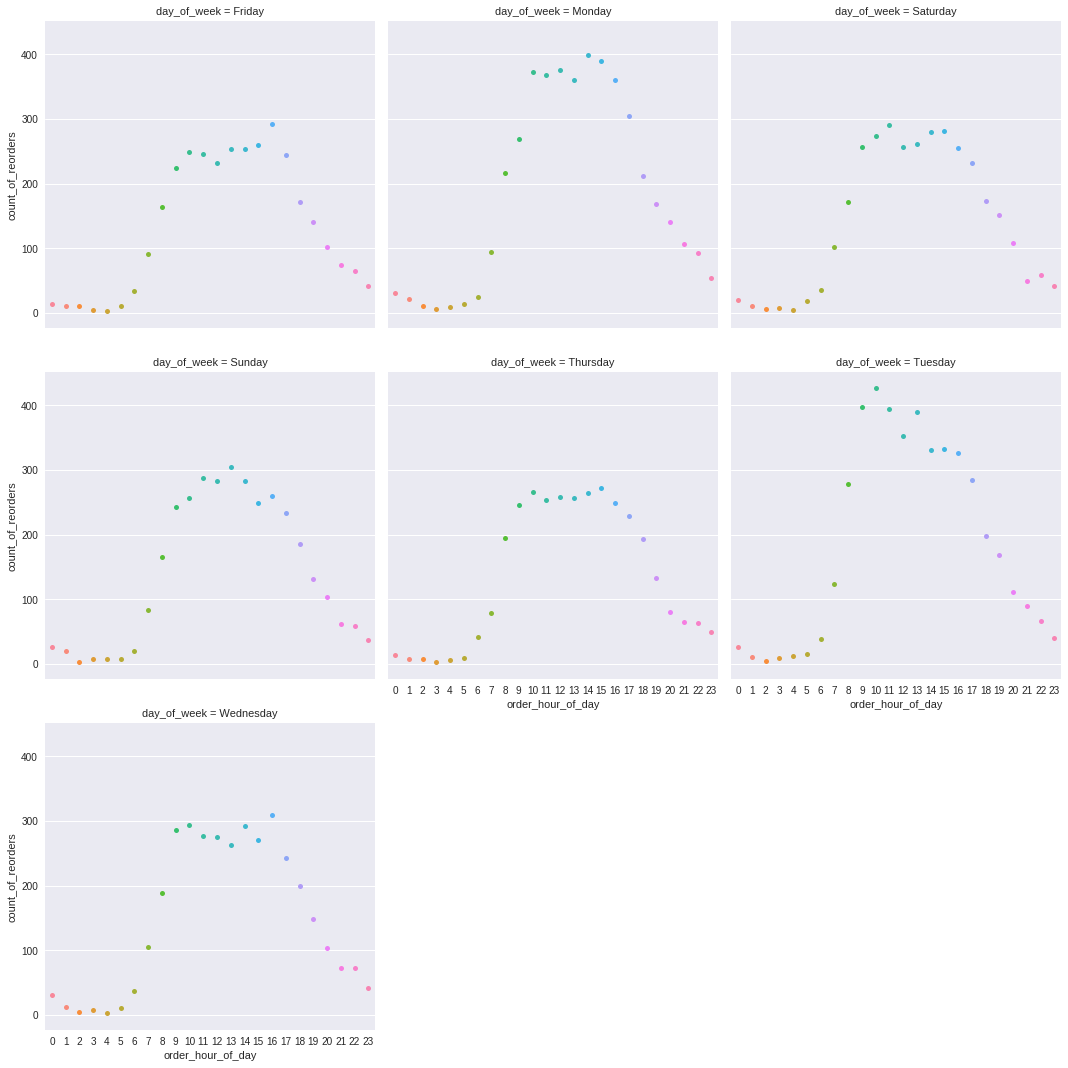

In [10]:
"""
Bivariate Analysis
1. When do people order (Distribution of Time of Day by orders) ?
2. Day of Week (Distribution of day_of_week by orders)?
"""
temp_df_01 = pd.DataFrame(prior_datamart.groupby(['day_of_week','order_hour_of_day','reordered'])
                          .agg({'order_id':pd.Series.nunique})
                          .rename(columns={'order_id':'count_of_reorders'})).reset_index()
plt.close('all')
sns.factorplot(x='order_hour_of_day', y='count_of_reorders',
               col="day_of_week", data=temp_df_01[temp_df_01['reordered']==1], kind="swarm",col_wrap=3,size=5);

del temp_df_01


 Top 10 products for Day and Time Combination
   day_of_week  order_hour_of_day            product_name  reordered  \
0      Friday                 14                  Banana          1   
1      Friday                 15                  Banana          1   
2      Friday                 12                  Banana          1   
3      Friday                  9                  Banana          1   
4      Friday                 16  Bag of Organic Bananas          1   

   count_of_reorders  
0                 43  
1                 42  
2                 39  
3                 37  
4                 35  


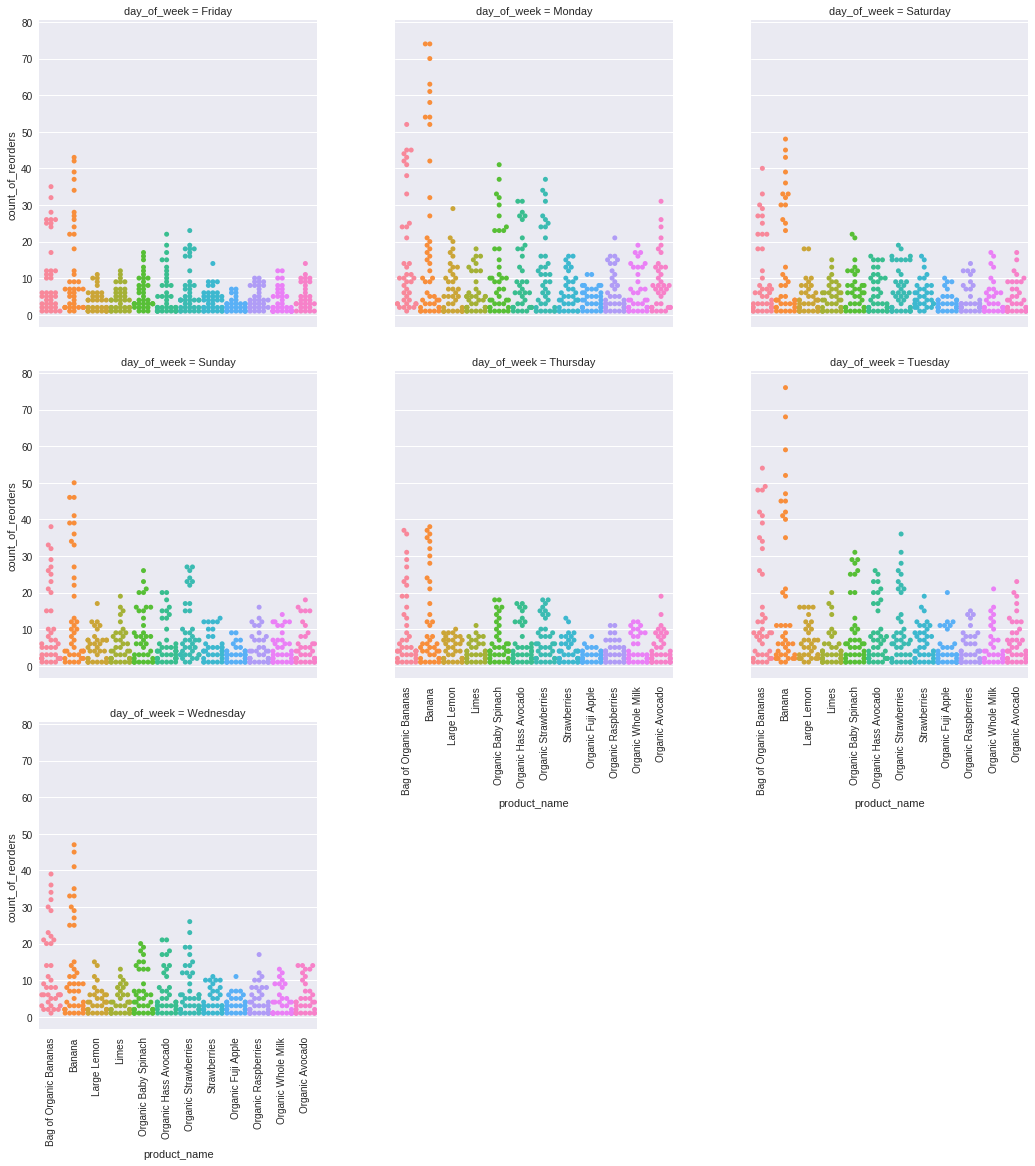

In [11]:
"""
Bivariate Analysis
Mondays and Tuesdays are busy days. It will be interesting to look for type of products ordered on Monday and Tuesdays
during the peak time
"""
temp_groupby_01= prior_datamart.groupby(['day_of_week','order_hour_of_day','product_name',
                                         'reordered']).agg({'order_id':
                                                            pd.Series.nunique}).rename(columns={'order_id':
                                                                                                'count_of_reorders'})
temp_groupby_02 = temp_groupby_01['count_of_reorders'].groupby(level=0, group_keys=False)

temp_df_01 = pd.DataFrame(temp_groupby_01).reset_index()
temp_df_02 = pd.DataFrame(temp_groupby_02.nlargest(50)).reset_index()

top_10_products_by_DayAndTime = temp_df_02[temp_df_02['reordered']==1]
print("\n Top 10 products for Day and Time Combination\n",top_10_products_by_DayAndTime.head(5))

#Limit data to only those products which are in top 10 category by any time and day combination
temp_df_01 = temp_df_01[temp_df_01['product_name'].isin(top_10_products_by_DayAndTime['product_name'])]

#Monday and Tuesday are of interest
#temp_df_01 = temp_df_01[temp_df_01['day_of_week'].isin(['Monday','Tuesday'])] 

#Most orders are between 6 and 20
#temp_df_01 = temp_df_01[(temp_df_01['order_hour_of_day'] >= 6) & (temp_df_01['order_hour_of_day'] <= 20) ]

plt.close('all')
g = sns.factorplot(x='product_name', y='count_of_reorders',
                   #col="day_of_week", data=temp_df_01[temp_df_01['reordered']==1], kind="swarm",col_wrap=3,size=5);
                   col="day_of_week", data=temp_df_01, kind="swarm",col_wrap=3,size=5);
g.set_xticklabels(rotation=90)